In [95]:
import numpy as np
import pandas as pd
import ta
import scipy.stats
from datetime import datetime
import math
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import yfinance as yf


In [108]:
def preprocessing_yf(symbol):
    global df
 #Import data
    df = yf.download(symbol).dropna()

 #Rename
    df.columns = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
    df.index.name = "Date"

    #Remove adj close
    # del df["adj close"]

    return df

In [118]:
df = preprocessing_yf("^GSPC")
df = df.rename_axis('Date').reset_index()
# df['Date'] = df['Date'].strftime('%Y-%m-%d')

df.tail()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
24168,2024-03-19,5139.089844,5180.310059,5131.589844,5178.509766,5178.509766,4031760000
24169,2024-03-20,5181.689941,5226.189941,5171.549805,5224.620117,5224.620117,4064850000
24170,2024-03-21,5253.430176,5261.100098,5240.660156,5241.529785,5241.529785,4207730000
24171,2024-03-22,5242.479980,5246.089844,5229.870117,5234.180176,5234.180176,3374700000
24172,2024-03-25,5219.520020,5228.950195,5216.089844,5224.100098,5224.100098,967007377


In [81]:
# df = pd.read_csv("./data/SNP.csv")
# df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4888,2020-03-26,47.090000,47.799999,46.750000,47.400002,47.400002,281800
4889,2020-03-27,45.889999,46.689999,45.450001,45.509998,45.509998,406600
4890,2020-03-30,46.389999,48.020000,46.389999,47.660000,47.660000,390100
4891,2020-03-31,48.500000,49.320000,48.200001,48.700001,48.700001,223500
4892,2020-04-01,46.020000,48.570000,45.849998,47.529999,47.529999,316500


In [119]:
df = ta.add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Slow : 60+
# Fast : 15
# df['date'] = df['Date'].apply(lambda x: datetime.strptime(str(x),"%Y-%m-%d"))
df['dateInt'] = df['Date'].apply(lambda x: (x - datetime(1970,1,1)).days)

df.columns[25:]

Index(['volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo',
       'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_r

In [120]:
# Feature Vector Calculations.

df['priceChange'] = df['Close']-df['Open']
df['classPriceChange'] = df['priceChange']>0

# Fast SMA is 12 days
# Slow EMA is 26 days

df['medPrice'] = ((df['High']+df['Low'])/2)
df['typPrice'] = ((df['High']+df['Low']+df['Close'])/3)
df['wtyPrice'] = ((df['High']+df['Low']+2*df['Close'])/3)

In [121]:
df2 = pd.concat(
    [
        df[['classPriceChange','priceChange','Date','dateInt']],
        df[list(df.columns[7:93])].shift(1),
        df[list(df.columns[97:])].shift(1)
    ],
    axis=1)
df2 = df2[1:].reset_index(drop=True)
df2.head()
print(df2.iloc[:,1:5])
# print(df2[1:5])
# df3 = df2.iloc[:, ::-1]
# print(df3)

       priceChange       Date  dateInt    volume_adi
0         0.000000 1928-01-03   -15339  0.000000e+00
1         0.000000 1928-01-04   -15338  0.000000e+00
2         0.000000 1928-01-05   -15337  0.000000e+00
3         0.000000 1928-01-06   -15336  0.000000e+00
4         0.000000 1928-01-09   -15333  0.000000e+00
...            ...        ...      ...           ...
24167    39.419922 2024-03-19    19801  2.242783e+12
24168    42.930176 2024-03-20    19802  2.246517e+12
24169   -11.900391 2024-03-21    19803  2.250348e+12
24170    -8.299805 2024-03-22    19804  2.246499e+12
24171     4.580078 2024-03-25    19807  2.244917e+12

[24172 rows x 4 columns]


In [181]:
all_x = df2[df2.columns[3:]].values
all_y = df2['classPriceChange'].values
#df_input.head()

# Train on the range (01/01/2002) - (12/31/2018), keep (2000-2001) and (2019-2020)
train_test_mask = (df2['Date'] <= datetime(2019,1,1))&(df2['Date'] >= datetime(2001,1,1))

train_x = all_x[train_test_mask]
train_y = all_y[train_test_mask]

test_x = all_x[~train_test_mask]
test_y = all_y[~train_test_mask]
# print(train_test_mask)

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
30       False
31       False
32       False
33       False
34       False
35       False
36       False
37       False
38       False
39       False
40       False
41       False
42       False
43       False
44       False
45       False
46       False
47       False
48       False
49       False
50       False
51       False
52       False
53       False
54       False
55       False
56       False
57       False
58       False
59       False
60       False
61       False
62       False
63       False
64       False
65       False
66       F

In [123]:
print(df2.columns[3:])

Index(['dateInt', 'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi',
       'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_i

In [124]:
print(all_x.shape)
print(all_y.shape)

(24172, 89)
(24172,)


In [125]:
lda = LinearDiscriminantAnalysis()
X_train_new = lda.fit_transform(train_x,train_y)
# X_test = lda.transform(X_test)
# print(X_train_new)
print(train_x[1,:]==X_train_new[1])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]


In [126]:
# train_x[:,train_x[0,:] == X_train_new[0]]

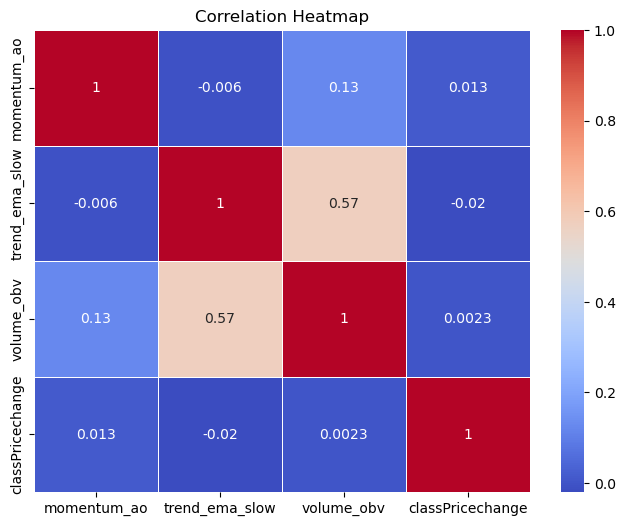

In [127]:
#CORRELATION HEATMAP

correlation_matrix = df3.corr(numeric_only = True)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

ValueError: Could not interpret value `Date` for parameter `x`

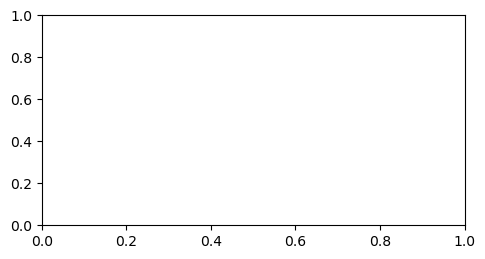

In [128]:
# Visualize the distribution of each feature using histograms.
plt.figure(figsize=(12, 6))
for i, feature in enumerate(df.columns):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data=df3, x=feature, hue='classPricechange', kde=True)
    plt.title(f'{feature} Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# Create a pair plot to visualize relationships between different features and corresponding binary outcomes.
ax = sns.pairplot(df3, hue='classPricechange', markers=["o", "s"])
plt.suptitle("Pair Plot of technical indicators Dataset")
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False)
plt.tight_layout()
plt.show()

In [129]:
myPipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda',LinearDiscriminantAnalysis()),
    ('gnb', GaussianNB())])

parameter_grid = {
    # 'pca__n_components':[10,20,40,80],
    'gnb__var_smoothing':np.logspace(-8,2,11)
}

clf = GridSearchCV(myPipeline,
                   parameter_grid,
                   cv=5,
                   return_train_score=True)
clf.fit(train_x,train_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lda', LinearDiscriminantAnalysis()),
                                       ('gnb', GaussianNB())]),
             param_grid={'gnb__var_smoothing': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02])},
             return_train_score=True)

Best Parameter Selected:	: {'gnb__var_smoothing': 10.0}
Holdout Confusion Matrix
[[8467 2863]
 [  83 8232]]
Holdout Model Accuracy:	 0.8500381776533469


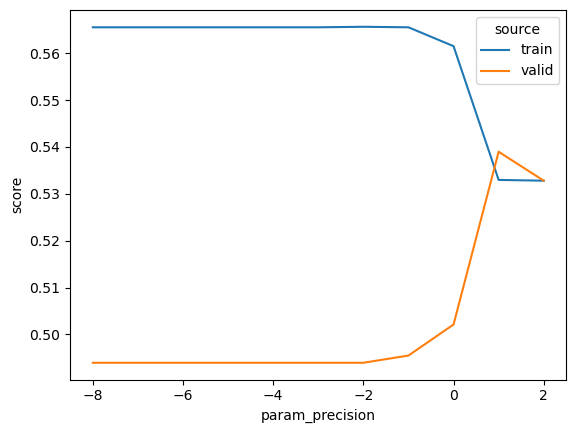

In [171]:
param_precision = [np.log10(x) for x in clf.cv_results_['param_gnb__var_smoothing'].data]

df_cvtrain = pd.DataFrame(
    {'source':'train',
     'param_precision':param_precision,
     'score':clf.cv_results_['mean_train_score']})

df_cvvalid = pd.DataFrame(
    {'source':'valid',
     'param_precision':param_precision,
     'score':clf.cv_results_['mean_test_score']})

df_cv = pd.concat([df_cvtrain,df_cvvalid])

sns.lineplot(data=df_cv, x="param_precision",y='score',hue="source")

test_yhat = clf.best_estimator_.predict(test_x)

print("Best Parameter Selected:\t:",clf.best_params_)
threshold = 0.34 #THRESHOLDING VALUE TO CHANGE WHAT THRESHOLD REQUIRES A BUY CALL (ANYTHING ABOVE THIS THRESHOLD PREDICTS UPWARD PRICE MOVEMENT)
test_yhat = (clf.best_estimator_.predict_proba(test_x)[:, 1] > threshold).astype('float')

print("Holdout Confusion Matrix")
print(confusion_matrix(test_y,test_yhat))

print("Holdout Model Accuracy:\t",accuracy_score(test_y,test_yhat))

In [159]:
# # pd.set_option("max_columns", None) # show all cols
# pd.options.display.max_colwidth = 100
# pd.set_option('max_colwidth', None) # show full width of showing cols
# pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be
# pd.options.display.max_seq_items = 200000
# pd.options.display.max_rows = 400000
# print(str(test_yhat))
# print(clf.best_estimator_.predict_proba(test_x))
# print((sum(clf.best_estimator_.predict_proba(test_x)[:, 1] > 0.6).astype('float')))
# # print(clf.best_estimator_.predict(test_x)[20:30])

[0. 0. 0. ... 0. 0. 0.]
[[1.         0.        ]
 [0.98839829 0.01160171]
 [0.98338692 0.01661308]
 ...
 [0.52527708 0.47472292]
 [0.51500238 0.48499762]
 [0.50551761 0.49448239]]
0.0


In [238]:
# print(test_yhat)
# print(df2.columns)
dummy = df['Close'].loc[df['Date']>=datetime(2020,1,1)]
print(df['Date'].loc[df['Date']>=datetime(2020,1,1)])
print(dummy)
print(dummy.iloc[1])
print(pct.iloc[1])

23109   2020-01-02
23110   2020-01-03
23111   2020-01-06
23112   2020-01-07
23113   2020-01-08
23114   2020-01-09
23115   2020-01-10
23116   2020-01-13
23117   2020-01-14
23118   2020-01-15
23119   2020-01-16
23120   2020-01-17
23121   2020-01-21
23122   2020-01-22
23123   2020-01-23
23124   2020-01-24
23125   2020-01-27
23126   2020-01-28
23127   2020-01-29
23128   2020-01-30
23129   2020-01-31
23130   2020-02-03
23131   2020-02-04
23132   2020-02-05
23133   2020-02-06
23134   2020-02-07
23135   2020-02-10
23136   2020-02-11
23137   2020-02-12
23138   2020-02-13
23139   2020-02-14
23140   2020-02-18
23141   2020-02-19
23142   2020-02-20
23143   2020-02-21
23144   2020-02-24
23145   2020-02-25
23146   2020-02-26
23147   2020-02-27
23148   2020-02-28
23149   2020-03-02
23150   2020-03-03
23151   2020-03-04
23152   2020-03-05
23153   2020-03-06
23154   2020-03-09
23155   2020-03-10
23156   2020-03-11
23157   2020-03-12
23158   2020-03-13
23159   2020-03-16
23160   2020-03-17
23161   2020

In [319]:

backtest_mask = (df2['Date'] >= datetime(2020,1,1))  #DATES TO USE BACKTEST TO DETERMINE PROFITABILITY
backtest_x = all_x[backtest_mask]
backtest_y = (clf.best_estimator_.predict_proba(backtest_x)[:, 1] > threshold).astype('float')
position = backtest_y*1
# print(position.shape)
position[position==0]=-1
# print(position)
index_values = df['Date'].loc[df['Date']>=datetime(2020,1,3)]
# print(index_values.shape)
dfpos=pd.DataFrame(position[1:],index=index_values)
print(dfpos.shape)
# print(df2['Date'].loc[backtest_mask])

# print(backtest_x.shape)
pct = df['Close'].loc[df['Date']>=datetime(2020,1,1)].pct_change(1).dropna() ##takes the percentage change of the close between each row, between every day since the input is 1, if input was 2, it would be the percent change of the stock over every 2 days
dfpct = pd.DataFrame(pct.values, index=index_values)
returnoninvestment = dfpct* dfpos.shift(1)  #calculate the return of our strategy (shift(1) tells program to use the previous position in the calculation because that tells us how much percent change that position has gained or lost from then to the present)
dfreturn = pd.DataFrame(returnoninvestment, index=index_values).dropna()
# print(dfreturn)
# dfreturn = dfreturn.rename(columns={'0':'return'})
dfreturn.name='return'
print(dfreturn)

(1063, 1)
                   0
Date                
2020-01-06  0.003533
2020-01-07 -0.002803
2020-01-08  0.004902
2020-01-09  0.006655
2020-01-10 -0.002855
2020-01-13  0.006976
2020-01-14 -0.001515
2020-01-15  0.001870
2020-01-16  0.008367
2020-01-17  0.003862
2020-01-21 -0.002652
2020-01-22  0.000289
2020-01-23  0.001141
2020-01-24 -0.009042
2020-01-27 -0.015731
2020-01-28  0.010054
2020-01-29 -0.000867
2020-01-30  0.003134
2020-01-31 -0.017706
2020-02-03  0.007255
2020-02-04  0.014980
2020-02-05  0.011251
2020-02-06  0.003326
2020-02-07 -0.005401
2020-02-10  0.007326
2020-02-11  0.001688
2020-02-12  0.006463
2020-02-13 -0.001630
2020-02-14  0.001844
2020-02-18 -0.002920
2020-02-19  0.004706
2020-02-20 -0.003816
2020-02-21 -0.010518
2020-02-24 -0.033514
2020-02-25 -0.030280
2020-02-26 -0.003779
2020-02-27 -0.044163
2020-02-28 -0.008238
2020-03-02  0.046039
2020-03-03 -0.028108
2020-03-04  0.042203
2020-03-05 -0.033922
2020-03-06 -0.017054
2020-03-09 -0.075970
2020-03-10  0.049396
202

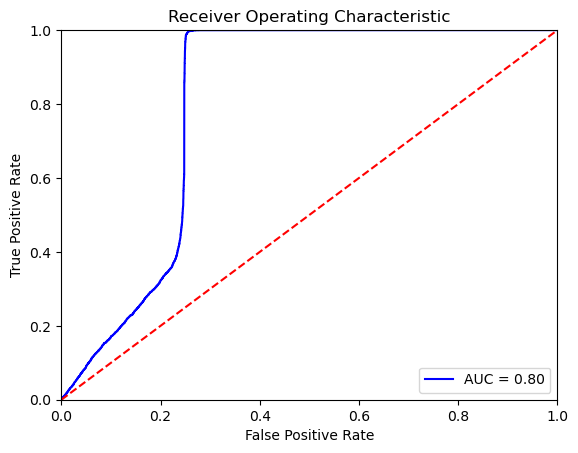

In [136]:
dfrom sklearn import metrics


probs = clf.predict_proba(test_x)
prob_prd = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(test_y, prob_prd)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
all_x.shape

(4892, 90)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
X = np.arange(6).reshape(3, 2)

In [137]:
def drawdown_function(series):
    cum = series.dropna().cumsum() + 1
    running_max = np.maximum.accumulate(cum)   #this function accumulates the max of the cumulative sum, for example (1,3,5,3,1) becomes (1,3,5,5,5) this will continue with 5 until a higher value comes along

    drawdown = cum/running_max -1
    return drawdown

[*********************100%%**********************]  1 of 1 completed


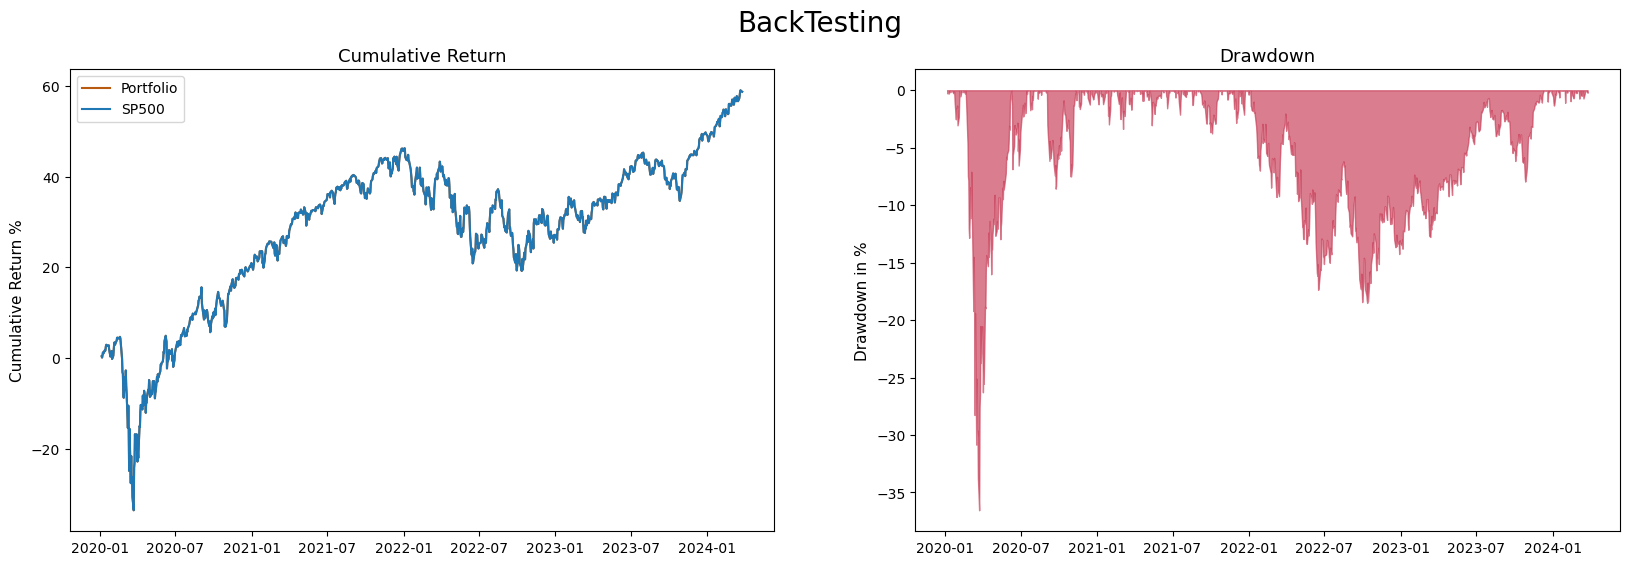

Sortino: 0.763
Beta:1.001
Alpha:-0.013 %
Max Drawdown:36.55 %


In [324]:
#### Backtest Function ####
def BackTest(series, annualized_scalar=252):   #default annualized_scalar data to 252 for daily sortino and alpha. if annualized_scalar = 12, this would correspond to monthly data.
    sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1) # import percent change of daily close every day

    sp500.name = "SP500" #Change the name
    series.name='return'
    val = pd.concat((series, sp500), axis=1).dropna() # put together the return of our data and the return of the sp500 concatenated along columns
  
    drawdown = drawdown_function(series) *100 # compute the drawdown (the risk of strategy)

    max_drawdown= - np.min(drawdown) #compute max drawdown

    fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6)) #initialize two subplots, 'cum' and 'dra'
    fig.suptitle("BackTesting", size=20)  #add subtitle


    cum.plot(series.cumsum()*100, color = "#B85A0F") # plot cumulative sum of returns for data
    cum.plot(val["SP500"].cumsum()*100)#, color = "B85A0F") #plot cumulative sum of returns for index (index meant to represent the market)
    cum.legend(["Portfolio", "SP500"])
    cum.set_title("Cumulative Return", size= 13)
    cum.set_ylabel("Cumulative Return %", size = 11)

    # print(drawdown)
    # print(drawdown.index)
    # print(drawdown.shape)
    dra.fill_between(drawdown.index, 0, drawdown, color = "#C73954", alpha=0.65) #Adds plot of the drawdown, with all the space between y=0 and y=drawdown being filled (what fill_between does) over the domain of the time the data takes place over fill_between(x, y1, y2=0)
    dra.set_title("Drawdown", size = 13)
    dra.set_ylabel("Drawdown in %", size=11)
    plt.show()
    # print(val)
    sortino = np.sqrt(annualized_scalar) * series.mean()/series.loc[series<0].std() #compute the sortino 
    beta = np.cov(val[["return", "SP500"]].values, rowvar=False)[0][1] / np.var(val["SP500"].values) #compute the beta
    alpha = (annualized_scalar) * series.mean() - (annualized_scalar)*beta*series.mean() #compute the alpha

    print(f"Sortino: {np.round(sortino,3)}")
    print(f"Beta:{np.round(beta,3)}")
    print(f"Alpha:{np.round(alpha*100,3)} %")
    print(f"Max Drawdown:{np.round(max_drawdown,3)} %")

    ######################
BackTest(dfreturn.squeeze())